In [1]:
# Pandas to read csv file and other things
import pandas as pd
# Datareader to download price data from Yahoo Finance
import pandas_datareader as web
# Statsmodels to run our multiple regression model
import statsmodels.api as smf
# To download the Fama French data from the web
import urllib.request
# To unzip the ZipFile 
import zipfile
import numpy as np

In [2]:
def get_fama_french():
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    
    # Download the file and save it
    # We will name it fama_french.zip file
    
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Next we extact the file data
    
    zip_file.extractall()
    
    # Make sure you close the file after extraction
    
    zip_file.close()
    
    # Now open the CSV file
    
    ff_factors = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows = 3, index_col = 0)
    # We want to find out the row with NULL value
    # We will skip these rows
    ff_factors= ff_factors.dropna()
    # Change date format
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m%d')
    ff_factors.index = ff_factors.index.strftime('%Y-%m-%d')
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

In [3]:
ff_factors= get_fama_french()

In [4]:
print(ff_factors)

            Mkt-RF     SMB     HML       RF
1926-07-01  0.0010 -0.0023 -0.0028  0.00009
1926-07-02  0.0045 -0.0034 -0.0003  0.00009
1926-07-06  0.0017  0.0029 -0.0038  0.00009
1926-07-07  0.0009 -0.0059  0.0000  0.00009
1926-07-08  0.0021 -0.0038  0.0018  0.00009
...            ...     ...     ...      ...
2022-04-25  0.0071  0.0045 -0.0184  0.00000
2022-04-26 -0.0300 -0.0066  0.0179  0.00000
2022-04-27  0.0012 -0.0060  0.0033  0.00000
2022-04-28  0.0244 -0.0018 -0.0045  0.00000
2022-04-29 -0.0353  0.0075  0.0058  0.00000

[25230 rows x 4 columns]


In [5]:
start_date='2018-08-3'
end_date='2022-05-2'

custom_factors=ff_factors.loc[start_date:end_date].copy()

#include gold and HY_Bond as factors
#gold_price = web.get_data_yahoo("GC=F", start_date, end_date)
#HY_Bond_price = web.get_data_yahoo("HYG", start_date, end_date)
#gold_price.index = gold_price.index.strftime('%Y-%m-%d')
#HY_Bond_price.index= HY_Bond_price.index.strftime('%Y-%m-%d')
#custom_factors['Gold'] = gold_price['Close'].pct_change()[1:]
#custom_factors['HY_Bond']= HY_Bond_price['Close'].pct_change()[1:]



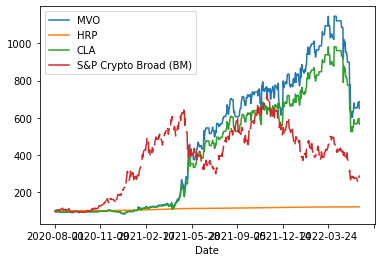

In [6]:
portfolio_daily_returns= pd.read_csv('port_return.csv', index_col = "Date")
#format date
portfolio_daily_returns.index = pd.to_datetime(portfolio_daily_returns.index, format = '%d/%m/%Y')
portfolio_daily_returns.index = portfolio_daily_returns.index.strftime('%Y-%m-%d')

#portfolio_daily_returns= portfolio_daily_returns.dropna()
#Calculate portfolio returns
portfolio_index=100*(1+portfolio_daily_returns).cumprod()
portfolio_index.plot()


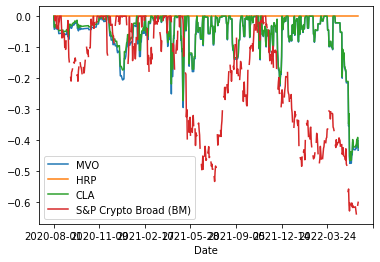

In [7]:
previous_peaks= portfolio_index.cummax()
drawdown=(portfolio_index-previous_peaks)/previous_peaks
drawdown.plot()


In [8]:
#Crypto Benchmark 3 factor
all_data = pd.merge(pd.DataFrame(portfolio_daily_returns),ff_factors, how = 'inner', left_index= True, right_index= True)
all_data.rename(columns={"Mkt-RF":"Mkt_excess"}, inplace=True)
all_data['Benchmark_excess'] = all_data['S&P Crypto Broad (BM)'] - all_data['RF']
Crypto_Bm_model = smf.formula.ols(formula = "Benchmark_excess ~ Mkt_excess + SMB + HML", data = all_data).fit()
print(Crypto_Bm_model.params)
print(Crypto_Bm_model.summary())


Intercept     0.003420
Mkt_excess    1.332480
SMB           0.369683
HML          -0.154340
dtype: float64
                            OLS Regression Results                            
Dep. Variable:       Benchmark_excess   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     22.18
Date:                Fri, 17 Jun 2022   Prob (F-statistic):           2.21e-13
Time:                        21:29:19   Log-Likelihood:                 777.04
No. Observations:                 440   AIC:                            -1546.
Df Residuals:                     436   BIC:                            -1530.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [9]:
#MVO 3 factor
all_data.rename(columns={"Mkt-RF":"Mkt_excess"}, inplace=True)
all_data['MVO_excess'] = all_data['MVO'] - all_data['RF']
mvo_model = smf.formula.ols(formula = "MVO_excess ~ Mkt_excess + SMB + HML", data = all_data).fit()
print(mvo_model.params)
print(mvo_model.summary())

Intercept     0.002883
Mkt_excess    0.255792
SMB           0.124391
HML           0.179618
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             MVO_excess   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.071
Date:                Fri, 17 Jun 2022   Prob (F-statistic):              0.361
Time:                        21:29:19   Log-Likelihood:                 800.81
No. Observations:                 440   AIC:                            -1594.
Df Residuals:                     436   BIC:                            -1577.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [10]:
#HRP 3 factor
all_data.rename(columns={"Mkt-RF":"Mkt_excess"}, inplace=True)
all_data['HRP_excess'] = all_data['HRP'] - all_data['RF']
HRP_model = smf.formula.ols(formula = "HRP_excess ~ Mkt_excess + SMB + HML", data = all_data).fit()
print(HRP_model.params)
print(HRP_model.summary())

Intercept     0.000316
Mkt_excess    0.001737
SMB          -0.001304
HML           0.001217
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             HRP_excess   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.281
Date:                Fri, 17 Jun 2022   Prob (F-statistic):              0.280
Time:                        21:29:19   Log-Likelihood:                 3090.1
No. Observations:                 440   AIC:                            -6172.
Df Residuals:                     436   BIC:                            -6156.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [11]:
#CLA 3 factor
all_data.rename(columns={"Mkt-RF":"Mkt_excess"}, inplace=True)
all_data['CLA_excess'] = all_data['CLA'] - all_data['RF']
cla_model = smf.formula.ols(formula = "CLA_excess ~ Mkt_excess + SMB + HML", data = all_data).fit()
print(cla_model.params)
print(cla_model.summary())

Intercept     0.002683
Mkt_excess    0.237466
SMB           0.121135
HML           0.158905
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             CLA_excess   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.051
Date:                Fri, 17 Jun 2022   Prob (F-statistic):              0.370
Time:                        21:29:19   Log-Likelihood:                 831.75
No. Observations:                 440   AIC:                            -1655.
Df Residuals:                     436   BIC:                            -1639.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [12]:
def annual_returns(returns):

    num_years = len(returns) / 252

    cum_ret_final = (returns + 1).prod().squeeze()

    return cum_ret_final ** (1 / num_years) - 1
def sharpe(returns, risk_free=0):
    adj_returns = returns - risk_free
    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / np.nanstd(adj_returns, ddof=1)

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)


def sortino(returns, risk_free=0):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)

    if drisk == 0:
        return np.nan

    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / drisk

In [13]:
print("**Annualised Return**")
print('MVO:',annual_returns(portfolio_daily_returns['MVO']))
print('HRP:',annual_returns(portfolio_daily_returns['HRP']))
print('CLA:',annual_returns(portfolio_daily_returns['CLA']))
print('S&P Crypto Broad (BM):',annual_returns(portfolio_daily_returns['S&P Crypto Broad (BM)']))

**Annualised Return**
MVO: 1.0241624361637718
HRP: 0.0801754603394007
CLA: 0.9209668522987855
S&P Crypto Broad (BM): 0.48914629300579104


In [14]:
print("**Maximum drawdown**")
print(drawdown.min())

**Maximum drawdown**
MVO                     -0.474806
HRP                      0.000000
CLA                     -0.465022
S&P Crypto Broad (BM)   -0.637527
dtype: float64


In [15]:
#Sortino Ratio risk_free set as 2 percent per annum
print("**Sortino Ratio**")
print('MVO:',sortino(portfolio_daily_returns['MVO'],risk_free=0.02/365))
print('HRP:',sortino(portfolio_daily_returns['HRP'],risk_free=0.02/365))
print('CLA:',sortino(portfolio_daily_returns['CLA'],risk_free=0.02/365))
print('S&P Crypto Broad (BM):',sortino(portfolio_daily_returns['S&P Crypto Broad (BM)'],risk_free=0.02/365))



**Sortino Ratio**
MVO: 0.14597742861625954
HRP: 106.2475194293668
CLA: 0.14180683067987554
S&P Crypto Broad (BM): 0.10152837181519381


In [16]:
#Sharpe Ratio risk_free set as 2 percent per annum
print("**Sharpe Ratio**")
print('MVO:',sharpe(portfolio_daily_returns['MVO'],risk_free=0.02/365))
print('HRP:',sharpe(portfolio_daily_returns['HRP'],risk_free=0.02/365))
print('CLA:',sharpe(portfolio_daily_returns['CLA'],risk_free=0.02/365))
print('S&P Crypto Broad (BM):',sharpe(portfolio_daily_returns['S&P Crypto Broad (BM)'],risk_free=0.02/365))


**Sharpe Ratio**
MVO: 1.4362603630054187
HRP: 18.265571403946264
CLA: 1.4072368743755648
S&P Crypto Broad (BM): 1.1223710069912114
